# Surveillance cameras EDA

Camille Seaberry

In [1]:
import numpy as np 
import cv2
import random 
import os 
import pandas as pd
import geopandas as gpd
import json
from pathlib import Path
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## Camera images and annotations

Annotation data was collected from the original data sources (Sheng et al and Objects365), cleaned up on the Roboflow platform, and re-exported in COCO format. I created augmented versions of images to increase the size of the training set by adding randomized small rotations and horizontal flips. There are two datasets here, one of full images possibly containing more than one camera in the frame, and one of images cropped to just the bounding box of a single camera instance.

Note that because of the number of images and their size, for now they're kept out of the github repo. In addition to the training set I analyze here, both datasets also have test and validation splits.

In [2]:
cams_full = {}
cams_crop = {}
for split in ['train', 'test', 'valid']:
  full_path = Path('../data/cams_coco') / split / '_annotations.coco.json'
  crop_path = Path('../data/cams_crop') / split / '_annotations.coco.json'
  with open(full_path) as f:
    cams_full[split] = json.load(f)
  with open(crop_path) as f:
    cams_crop[split] = json.load(f)
    
print(f"keys in full images: { cams_full['train'].keys() }")
print(f"keys in cropped images: { cams_crop['train'].keys() }")

print(f'\nexample of annotations for a single image:')
pprint(cams_full['train']['annotations'][0])

print(f'\nexample of metadata for a single image:')
pprint(cams_full['train']['images'][0])

keys in full images: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
keys in cropped images: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

example of annotations for a single image:
{'area': 135,
 'bbox': [554, 246, 15, 9],
 'category_id': 1,
 'id': 0,
 'image_id': 0,
 'iscrowd': 0,
 'segmentation': []}

example of metadata for a single image:
{'date_captured': '2023-05-20T17:59:59+00:00',
 'file_name': 'x6NQQwp1XjZv43rNbMBvEA_265_jpg.rf.842d5c5e0d08e84f97063f79c63fe332.jpg',
 'height': 640,
 'id': 0,
 'license': 1,
 'width': 640}


In [3]:
full_all_anns = pd.concat({ k: pd.DataFrame(v['annotations']) for k, v in cams_full.items() })
crop_all_anns = pd.concat({ k: pd.DataFrame(v['annotations']) for k, v in cams_crop.items() })

print(f'Full images annotations, all splits shape: { full_all_anns.shape }')
print(f'Cropped images annotations, all splits shape: { crop_all_anns.shape }')

full_all_imgs = pd.concat({ k: pd.DataFrame(v['images']) for k, v in cams_full.items() })
crop_all_imgs = pd.concat({ k: pd.DataFrame(v['images']) for k, v in cams_crop.items() })

print(f'Full images metadata, all splits shape: { full_all_imgs.shape }')
print(f'Cropped images metadata, all splits shape: { crop_all_imgs.shape }')

Full images annotations, all splits shape: (5347, 7)
Cropped images annotations, all splits shape: (2286, 7)
Full images metadata, all splits shape: (2896, 6)
Cropped images metadata, all splits shape: (2286, 6)


In [4]:
# before cleanup
print('Missing values in annotations & images:')
print(full_all_anns.isna().sum())
print(crop_all_anns.isna().sum())
print(full_all_imgs.isna().sum())
print(crop_all_imgs.isna().sum())

Missing values in annotations & images:
id              0
image_id        0
category_id     0
bbox            0
area            0
segmentation    0
iscrowd         0
dtype: int64
id              0
image_id        0
category_id     0
bbox            0
area            0
segmentation    0
iscrowd         0
dtype: int64
id               0
license          0
file_name        0
height           0
width            0
date_captured    0
dtype: int64
id               0
license          0
file_name        0
height           0
width            0
date_captured    0
dtype: int64


**Note:** EDA that follows will just be on training data.

In [5]:
meta_dfs = {}
meta_dfs['ann'] = {}
meta_dfs['img'] = {}
# ann_df = {}
# img_df = {}
for i, d in [('full', cams_full['train']), ('crop', cams_crop['train'])]:
  ann = pd.DataFrame(d['annotations'])
  ann = ann.set_index('id')
  ann = ann.drop(columns = ['segmentation', 'iscrowd'])
  meta_dfs['ann'][i] = ann
  
  img = pd.DataFrame(d['images'])
  img = img.set_index('id')
  img = img.drop(columns = ['license'])
  meta_dfs['img'][i] = img
 
meta_dfs = {
  k: pd.concat(v.values(), keys = v.keys(), names = ['type']) for k, v in meta_dfs.items()
}

In [6]:
print(f'annotations shape: { meta_dfs["ann"].shape }')
meta_dfs['ann'].head()

annotations shape: (5655, 4)


image_id  category_id               bbox   area
type id                                                 
full 0          0            1  [554, 246, 15, 9]  135.0
     1          1            1  [12, 185, 17, 12]  204.0
     2          2            1   [156, 288, 5, 6]   30.0
     3          3            1   [354, 342, 6, 9]   54.0
     4          4            1   [436, 275, 6, 6]   36.0

In [7]:
print(f'images shape: { meta_dfs["img"].shape }')
meta_dfs['img'].head()

images shape: (3557, 4)


file_name  height  width  \
type id                                                                     
full 0   x6NQQwp1XjZv43rNbMBvEA_265_jpg.rf.842d5c5e0d08...     640    640   
     1   objects365_v2_01454865_jpg.rf.8434f108ee5f717f...     640    640   
     2   5IprpXOq6f7qGQQ6xceqGw_237_jpg.rf.84889623389f...     640    640   
     3   objects365_v2_01283236_jpg.rf.84b3e3b94ed0586d...     640    640   
     4   3HhzTD6bXoV763vyxbwZHg_266_jpg.rf.84c1a7af28e0...     640    640   

                     date_captured  
type id                             
full 0   2023-05-20T17:59:59+00:00  
     1   2023-05-20T17:59:59+00:00  
     2   2023-05-20T17:59:59+00:00  
     3   2023-05-20T17:59:59+00:00  
     4   2023-05-20T17:59:59+00:00

Because there can be multiple cameras identified in one full image, the number of annotations in the full images dataset (4,610) is greater than the number of images in that same dataset (2,512). 

In [8]:
{ k: v.groupby('type').count().iloc[:, 0] for k, v in meta_dfs.items() }

{'ann': type
 crop    1045
 full    4610
 Name: image_id, dtype: int64,
 'img': type
 crop    1045
 full    2512
 Name: file_name, dtype: int64}

Categories to use for classification: 1 = directional, 2 = globe; 3 = not classified (Objects365 images are not classified). These are close to evenly split, with 48% being directional cameras. Directional cameras have a smaller mean bounding box size, as their bounding boxes are more oblong. All the cropped images are very small and blurry, however, which makes classification difficult. Full sized images are uniformly 640 x 640 pixels, but cropped images have mean dimensions of only 12 x 14 pixels.

In [9]:
meta_dfs['ann'].loc['crop', :] \
  .groupby('category_id') \
  .agg({'image_id': 'nunique', 'area': 'mean'}) \
  .loc[[1, 2], :]

,image_id,area
category_id,,
1,381,100.881890
2,418,134.880383


In [10]:
meta_dfs['img'].groupby('type').agg({'height': 'mean', 'width': 'mean'})

,height,width
type,,
crop,12.155981,14.32823
full,640.000000,640.00000


In [11]:
anns_x_img = pd.merge(
  meta_dfs['ann'].loc['full', :],
  meta_dfs['img'].loc['full', :],
  how = 'left', left_on = 'image_id', right_index = True
)
anns_x_img['n_per_img'] = 1 
anns_x_img = anns_x_img.groupby('image_id').agg({'n_per_img': 'sum'})

The vast majority of images have only 1 or 2 cameras marked in them. Some  have upwards of 15; checking for anomalies, it does seem realistic for some indoor scenes from the Objects365 data to have many cameras. For example, the highest number of annotations in an image is 24; this occurs 3 times, but all are augmentations of one image:

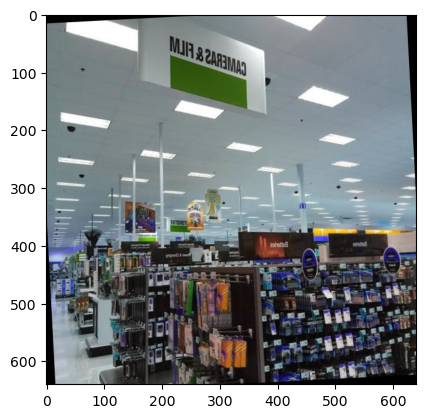

In [12]:
many_cams = anns_x_img.loc[anns_x_img['n_per_img'] > 20, :].index
  
many_cam_id = meta_dfs['img'].iloc[many_cams, :]['file_name'].values[0]
many_cam_img = cv2.imread(os.path.join('../data/cams_coco/train', many_cam_id))
plt.imshow(many_cam_img)
plt.show()

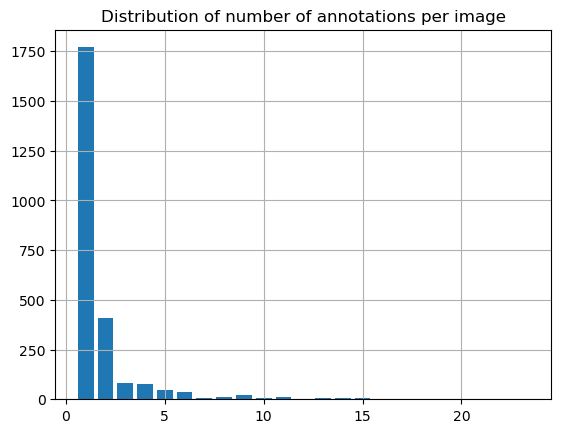

In [13]:
anns_hist = anns_x_img['n_per_img'].hist(bins = range(1, 25), rwidth = 0.8, align = 'left')
anns_hist.set_title('Distribution of number of annotations per image')
plt.show()

Finally, a sample of some of the cropped images:

In [14]:
meta_dfs['ann'].loc['crop'].groupby('category_id').count()

,image_id,bbox,area
category_id,,,
1,381,381,381
2,418,418,418
3,246,246,246


category: 1


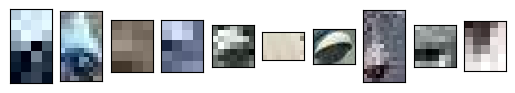

category: 2


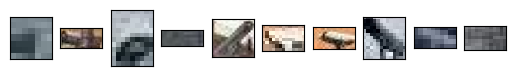

In [15]:
crop_sample = meta_dfs['ann'].loc['crop'].groupby('category_id').head(10)
crop_sample = crop_sample.loc[crop_sample['category_id'].isin([1, 2]), :]
crop_sample = crop_sample.merge(meta_dfs['img'].loc['crop', :], 
                                how = 'left', left_on = 'image_id', right_index = True)
crop_sample = crop_sample.loc[:, ['image_id', 'category_id', 'file_name']]

  
for cat_id in [1, 2]:
  cat_sample = crop_sample.loc[crop_sample['category_id'] == cat_id, :]
  imgs = [cv2.imread(os.path.join('../data/cams_crop/train', f))
          for f in cat_sample['file_name'].values]
  n = len(imgs)
  fig, axs = plt.subplots(ncols = n, squeeze = False)
  for i in range(n):
    img_grid = plt.subplot(1, 10, i + 1)
    img_grid.imshow(imgs[i])
    img_grid.set_xticks([])
    img_grid.set_yticks([])
  print(f'category: { cat_id }')
  plt.show()
  

## Possible route to take: updating Street View images

One task I might undertake is to update the Google Street View images I use after training the model. The Street View images I have trained on already are from the 2021 Sheng, et al paper, so to create up-to-date location data I would need current Street View images. Since cameras tend to be at street intersections, I can sample intersections from the city's road network and download Street View images for those locations from Google's Street View static API. 

The road network comes from OpenStreetMap via the OSMnx package. Download and clean-up are done in the script [`./prep_streets.py`](./prep_streets.py). The dataset `street_coords` is the result of that script, with just the IDs and coordinates of the nodes (intersections) of a simplified version of the road network.

In [16]:
streets = gpd.read_file('../data/input_data/street_coords.gpkg').to_crs(4326)
print(f'streets shape: { streets.shape }')
print(f'streets crs: { streets.crs}')
streets.head()

streets shape: (24274, 4)
streets crs: EPSG:4326


,id,lon,lat,geometry
0,27033798,-76.622936,39.267199,POINT (-76.62294 39.26720)
1,2703504304,-76.619563,39.267181,POINT (-76.61956 39.26718)
2,27033900,-76.554497,39.272539,POINT (-76.55450 39.27254)
3,49432572,-76.550587,39.277606,POINT (-76.55059 39.27761)
4,27033915,-76.546532,39.284076,POINT (-76.54653 39.28408)


Text(0.5, 1.0, 'Street intersections in Baltimore')

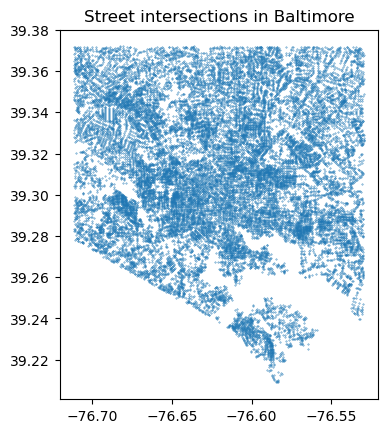

In [17]:
street_map = streets.plot(markersize = 0.1)
street_map.set_title('Street intersections in Baltimore')